In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_curve, auc

from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

# Sätt stil för plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

### Ladda data

In [32]:
file_path = os.path.join('data', 'trips_combined_total.parquet')
df_processed = pd.read_parquet(file_path)


In [33]:
# Diagnosfunktion för DataFrame för att identifiera problem som dubblerade index, kolumner och inbäddade DataFrames. Gjordes endast för försöka hitta problem vid prediktionsdata laddning.
def diagnose_dataframe(df, name="DataFrame", max_examples=3):
    print(f"\n{'='*80}")
    print(f"🔍 Diagnos för {name}")
    print(f"{'='*80}")
    print(f"Shape: {df.shape}")
    
    # 1️⃣ Dubblerade index
    duplicated_index_count = df.index.duplicated().sum()
    if duplicated_index_count > 0:
        print(f"❌ Dubblerade index hittade: {duplicated_index_count}")
        print(f"  Exempel på duplicerade index: {df.index[df.index.duplicated()][:max_examples].tolist()}")
    else:
        print("✅ Inga dubblerade index.")
    
    # 2️⃣ Dubblerade kolumner
    duplicated_cols = df.columns[df.columns.duplicated()].tolist()
    if duplicated_cols:
        print(f"❌ Dubblerade kolumner: {duplicated_cols}")
    else:
        print("✅ Inga dubblerade kolumnnamn.")
    
    # 3️⃣ Kolumner som är DataFrames (vanligt dubblettfel)
    nested_df_cols = [c for c in df.columns if isinstance(df[c].iloc[0], (pd.DataFrame, pd.Series, list, dict))]
    if nested_df_cols:
        print(f"⚠️ Kolumner med inbäddade strukturer: {nested_df_cols}")
        for c in nested_df_cols:
            print(f"  - '{c}' exempel: {df[c].iloc[0]}")
    else:
        print("✅ Inga kolumner med inbäddade strukturer (DataFrame/list/dict).")
    
    # 4️⃣ Snabb unicitetsöversikt
    print("\n📊 Snabb översikt av unika värden per kolumn:")
    uniq_counts = df.nunique(dropna=False).sort_values()
    display(uniq_counts.head(10))
    print("...")
    display(uniq_counts.tail(10))
    
    print(f"{'='*80}\n")


In [34]:
diagnose_dataframe(df_processed, "Efter inläsning av träningsdata")


🔍 Diagnos för Efter inläsning av träningsdata
Shape: (43210, 24)
✅ Inga dubblerade index.
✅ Inga dubblerade kolumnnamn.
✅ Inga kolumner med inbäddade strukturer (DataFrame/list/dict).

📊 Snabb översikt av unika värden per kolumn:


start_month            1
Canceled               2
is_weekday             2
is_delayed             2
trip_typeoftraffic     3
Operator              14
start_day_of_month    18
TripStartDate         18
TrainOwner            22
end_station_county    23
dtype: int64

...


LocationSignatureArrival        245
LocationSignatureDeparture      269
departure_station               269
DurationActualMinutes           562
DistanceKm                      664
AdvertisedTrainIdent           4105
DepartureAdvertised           15852
ArrivalAdvertised             16222
DepartureActual               42016
ArrivalActual                 42202
dtype: int64

### Första inspektion

In [35]:
print("Dataset shape:", df_processed.shape)
print("\nFirst rows:")
display(df_processed.head())
print("\nData types:")
print(df_processed.dtypes)
print("\nMissing values:")
print(df_processed.isnull().sum())
print("\nBasic statistics:")
display(df_processed.describe())

Dataset shape: (43210, 24)

First rows:


,AdvertisedTrainIdent,TripStartDate,LocationSignatureDeparture,LocationSignatureArrival,DepartureAdvertised,DepartureActual,ArrivalAdvertised,ArrivalActual,DelayMinutes,DurationActualMinutes,...,trip_typeoftraffic,departure_station,arrival_station,end_station_county,Deviation_Description,start_hour,start_day_of_month,start_month,is_weekday,is_delayed
0,10994,2025-10-09,Cst,U,2025-10-09 22:11:00,2025-10-09 22:11:24,2025-10-09 22:51:00,2025-10-09 22:49:17,-2,38,...,YNA001,Stockholms central,Uppsala central,Uppsala län,None,22,9,10,1,0
1,1154,2025-10-09,Mc,Hb,2025-10-09 22:12:00,2025-10-09 22:12:51,2025-10-09 22:53:00,2025-10-09 22:52:44,0,40,...,YNA001,Malmö central,Helsingborgs central,Skåne län,None,22,9,10,1,0
2,1156,2025-10-09,Hie,Lu,2025-10-09 22:18:00,2025-10-09 22:18:43,2025-10-09 22:40:00,2025-10-09 22:39:13,-1,20,...,YNA001,Hyllie,Lund c,Skåne län,None,22,9,10,1,0
3,1160,2025-10-09,Hie,Lu,2025-10-09 22:48:00,2025-10-09 22:48:21,2025-10-09 23:09:00,2025-10-09 23:11:39,3,23,...,YNA001,Hyllie,Lund c,Skåne län,None,22,9,10,1,0
4,1162,2025-10-09,Hie,Lu,2025-10-09 23:03:00,2025-10-09 23:03:22,2025-10-09 23:22:00,2025-10-09 23:22:53,1,20,...,YNA001,Hyllie,Lund c,Skåne län,None,23,9,10,1,0



Data types:
AdvertisedTrainIdent                  object
TripStartDate                         object
LocationSignatureDeparture            object
LocationSignatureArrival              object
DepartureAdvertised           datetime64[ns]
DepartureActual               datetime64[ns]
ArrivalAdvertised             datetime64[ns]
ArrivalActual                 datetime64[ns]
DelayMinutes                           int64
DurationActualMinutes                  int64
DistanceKm                           float64
Canceled                                bool
Operator                              object
TrainOwner                            object
trip_typeoftraffic                    object
departure_station                     object
arrival_station                       object
end_station_county                    object
Deviation_Description                 object
start_hour                             int64
start_day_of_month                     int64
start_month                            int

,DepartureAdvertised,DepartureActual,ArrivalAdvertised,ArrivalActual,DelayMinutes,DurationActualMinutes,DistanceKm,start_hour,start_day_of_month,start_month,is_weekday,is_delayed
count,43210,43210,43210,43210,43210.00,43210.00,43210.00,43210.00,43210.00,43210.00,43210.00,43210.00
mean,2025-10-18 07:42:54.074982400,2025-10-18 07:44:13.896489984,2025-10-18 09:10:47.830595072,2025-10-18 09:13:08.631519232,2.34,88.92,94.40,11.05,17.84,10.00,0.71,0.20
min,2025-10-09 22:00:00,2025-10-09 22:00:11,2025-10-09 22:25:00,2025-10-09 22:25:11,-159.00,-88.00,0.00,0.00,9.00,10.00,0.00,0.00
25%,2025-10-13 19:10:15,2025-10-13 19:11:36.750000128,2025-10-13 20:39:00,2025-10-13 20:39:42,-1.00,34.00,36.47,6.00,13.00,10.00,0.00,0.00
50%,2025-10-17 20:08:00,2025-10-17 20:09:42,2025-10-17 21:25:00,2025-10-17 21:26:33.500000,0.00,68.00,62.27,11.00,17.00,10.00,1.00,0.00
75%,2025-10-22 18:40:00,2025-10-22 18:41:44.750000128,2025-10-22 20:11:45,2025-10-22 20:15:55.500000,2.00,106.00,99.88,15.00,22.00,10.00,1.00,0.00
max,2025-10-26 22:54:00,2025-10-26 22:56:48,2025-10-26 22:59:00,2025-10-27 01:06:17,325.00,1467.00,527.67,23.00,26.00,10.00,1.00,1.00
std,NaN,NaN,NaN,NaN,8.54,91.54,94.05,5.53,4.96,0.00,0.45,0.40


### Exploratory Data Analysis (EDA)

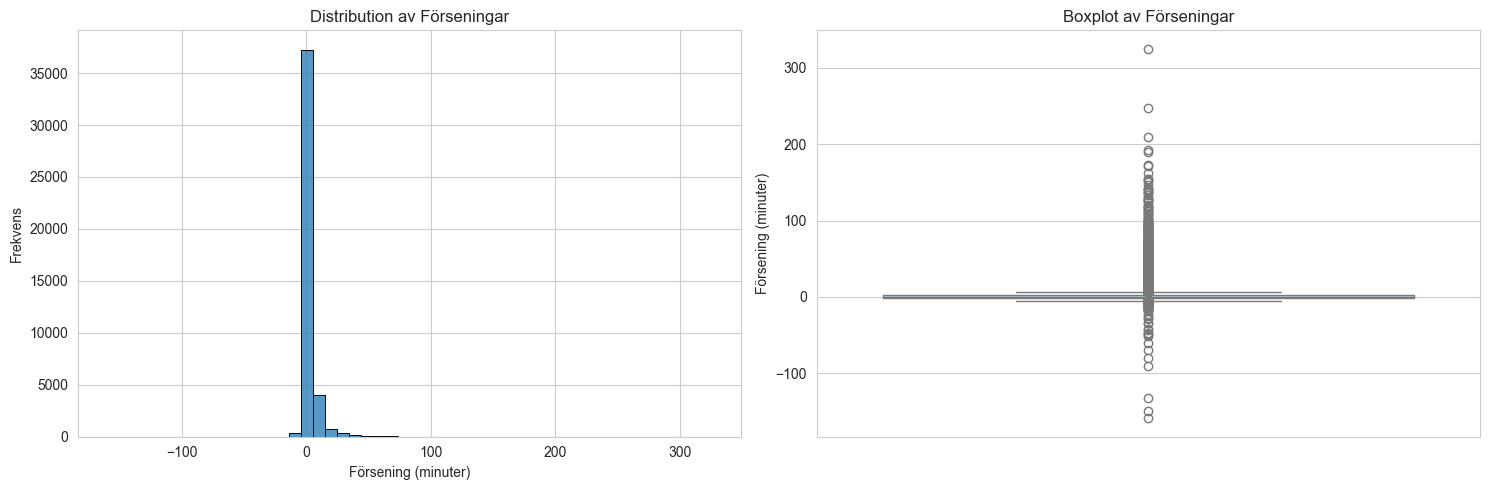

Medel försening: 2.34 min
Median försening: 0.00 min
Max försening: 325.00 min


In [36]:
# Distribution av target variabel med Seaborn
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# --- Vänstra diagrammet: Seaborn Histplot (Histogram och KDE) ---
sns.histplot(
    data=df_processed, 
    x='DelayMinutes', 
    bins=50, 
    kde=False, # Lägger till en skattning av täthetsfunktionen (Density Estimate)
    edgecolor='black',
    ax=axes[0]
)
axes[0].set_title('Distribution av Förseningar')
axes[0].set_xlabel('Försening (minuter)')
axes[0].set_ylabel('Frekvens')

# --- Högra diagrammet: Seaborn Boxplot (För outliers) ---
# Vi använder Seaborn boxplot och sätter x=None och y='DelayMinutes' 
# för att rita en vertikal boxplot.
sns.boxplot(
    data=df_processed, 
    y='DelayMinutes', 
    ax=axes[1],
    color='lightblue' # Lägger till en färg för tydlighet
)
axes[1].set_title('Boxplot av Förseningar')
axes[1].set_ylabel('Försening (minuter)')
axes[1].set_xlabel('') # Tar bort X-axeln genom att sätta en tom etikett

plt.tight_layout()
plt.show()

# Utskrift av statistik (oförändrad)
print(f"Medel försening: {df_processed['DelayMinutes'].mean():.2f} min")
print(f"Median försening: {df_processed['DelayMinutes'].median():.2f} min")
print(f"Max försening: {df_processed['DelayMinutes'].max():.2f} min")

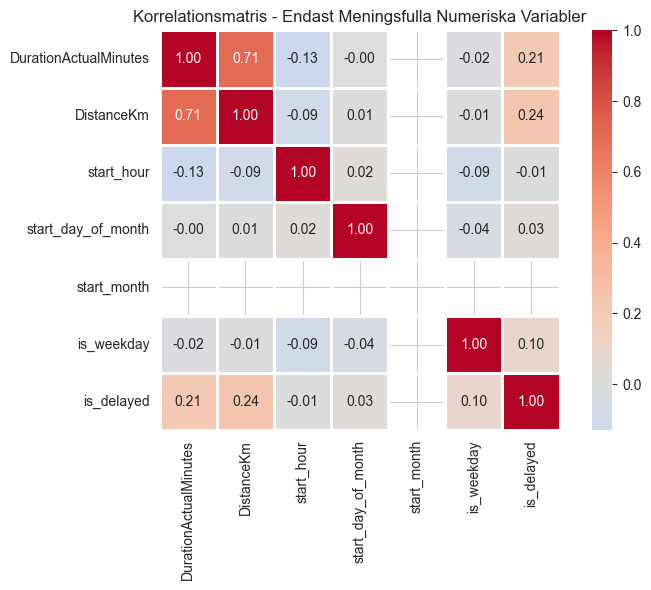

In [37]:
# 1. Välj alla numeriska kolumner
numeric_cols = df_processed.select_dtypes(include=[np.number]).columns

# 2. Exkludera alla Label Encoded-kolumner (de slutar på '_encoded') och exkludera tidigare target (DelayMinutes) -gör nu binär predictiv modellering på is_delayed (som är 3 min försenad)
excluded_suffixes = ('_encoded', 'DelayMinutes')

filtered_numeric_cols = [
    col for col in numeric_cols 
    if not col.endswith(excluded_suffixes) 
]
    
# 3. Beräkna korrelationsmatrisen
correlation_matrix = df_processed[filtered_numeric_cols].corr()

plt.figure(figsize=(8, 6))
# Här kan det vara meningsfullt att titta på korrelationen mot target-variabeln
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap='coolwarm', 
    center=0, 
    fmt='.2f', 
    square=True, 
    linewidths=1
)
plt.title('Korrelationsmatris - Endast Meningsfulla Numeriska Variabler')
plt.tight_layout()
plt.show()

In [38]:
# Feature importance 
print("\nKorrelation med is_delayed:")
print(correlation_matrix['is_delayed'].sort_values(ascending=False))


Korrelation med is_delayed:
is_delayed               1.00
DistanceKm               0.24
DurationActualMinutes    0.21
is_weekday               0.10
start_day_of_month       0.03
start_hour              -0.01
start_month               NaN
Name: is_delayed, dtype: float64


### Feature Engineering

In [39]:
# Feature Engineering
df_processed = df_processed.copy()

# Skapa en ny kolumn för klassificering
df_processed['is_delayed_6min'] = (df_processed['DelayMinutes'] >= 6).astype(int)

# VIKTIGT: Konvertera datetime-kolumner till pandas datetime
datetime_cols = ['start_planned', 'start_actual', 'end_planned', 'end_actual']
for col in datetime_cols:
    if col in df_processed.columns:
        df_processed[col] = pd.to_datetime(df_processed[col])

# Extrahera TIME-based features från datetime
if 'start_planned' in df_processed.columns:
    df_processed['start_minute'] = df_processed['start_planned'].dt.minute
    df_processed['start_day_of_month'] = df_processed['start_planned'].dt.day

# Planerad duration
if 'end_planned' in df_processed.columns and 'start_planned' in df_processed.columns:
    df_processed['planned_duration_min'] = (
        df_processed['end_planned'] - df_processed['start_planned']
    ).dt.total_seconds() / 60

# Rush hour feature
df_processed['is_rush_hour'] = df_processed['start_hour'].isin([7,8,9,16,17,18]).astype(int)

# Hantera kategoriska variabler med Label Encoding
label_encoders = {}
# UPPDATERAD lista för att matcha dina nya kolumner
categorical_cols = [
    'LocationSignatureDeparture', 
    'LocationSignatureArrival', 
    'Operator', 
    'TrainOwner', 
    'trip_typeoftraffic', 
    'departure_station', 
    'arrival_station',
    #'end_station_county'   # Verkar inte finnas med i prediktionsfilen
]

print("Skapar Label Encoded-features...")
for col in categorical_cols:
    if col in df_processed.columns:
        le = LabelEncoder()
        
        # <<< FIX & DEBUG: Tvinga 1D-array INNAN fit_transform(), för att förska hitta problem vid prediktion>>>
        # Säkerställ att allt hanteras som strängar, fyll NaN med 'UNKNOWN', 
        # konvertera till NumPy-array, och tvinga 1D (ravel).
        X_1d_train = df_processed[col].astype(str).fillna('UNKNOWN').to_numpy().ravel()
        
        # DEBUG: Kontrollera längden på datan som matas in
        print(f"DEBUG TRÄNING '{col}': Data inmatad med längd: {len(X_1d_train)}")
        
        # 2. Fit och Transform
        df_processed[col + '_encoded'] = le.fit_transform(X_1d_train)
        
        label_encoders[col] = le
        print(f"  - {col}_encoded skapad.")
    else:
        print(f"  - VARNING: {col} hittades inte i datan.")

# Kolla nya features (resten av koden i cellen)
# ...

Skapar Label Encoded-features...
DEBUG TRÄNING 'LocationSignatureDeparture': Data inmatad med längd: 43210
  - LocationSignatureDeparture_encoded skapad.
DEBUG TRÄNING 'LocationSignatureArrival': Data inmatad med längd: 43210
  - LocationSignatureArrival_encoded skapad.
DEBUG TRÄNING 'Operator': Data inmatad med längd: 43210
  - Operator_encoded skapad.
DEBUG TRÄNING 'TrainOwner': Data inmatad med längd: 43210
  - TrainOwner_encoded skapad.
DEBUG TRÄNING 'trip_typeoftraffic': Data inmatad med längd: 43210
  - trip_typeoftraffic_encoded skapad.
DEBUG TRÄNING 'departure_station': Data inmatad med längd: 43210
  - departure_station_encoded skapad.
DEBUG TRÄNING 'arrival_station': Data inmatad med längd: 43210
  - arrival_station_encoded skapad.


In [40]:
# Diagnostisera DataFrame efter feature engineering för att säkerställa att allt ser bra ut
diagnose_dataframe(df_processed, "Efter feature engineering")


🔍 Diagnos för Efter feature engineering
Shape: (43210, 33)
✅ Inga dubblerade index.
✅ Inga dubblerade kolumnnamn.
✅ Inga kolumner med inbäddade strukturer (DataFrame/list/dict).

📊 Snabb översikt av unika värden per kolumn:


start_month                    1
Canceled                       2
is_weekday                     2
is_delayed                     2
is_delayed_6min                2
is_rush_hour                   2
trip_typeoftraffic_encoded     3
trip_typeoftraffic             3
Operator                      14
Operator_encoded              14
dtype: int64

...


LocationSignatureDeparture      269
departure_station_encoded       269
departure_station               269
DurationActualMinutes           562
DistanceKm                      664
AdvertisedTrainIdent           4105
DepartureAdvertised           15852
ArrivalAdvertised             16222
DepartureActual               42016
ArrivalActual                 42202
dtype: int64

In [41]:
# Kolla nya features
print("Nya features skapade:")
new_features = ['start_minute', 'start_day_of_month', 'delay_at_start_min', 
                'delay_at_end_min', 'planned_duration_min', 'is_rush_hour', 
                'is_delayed_6min']
existing_new = [f for f in new_features if f in df_processed.columns]
print("Numeriska:", existing_new)

encoded_features = [col for col in df_processed.columns if col.endswith('_encoded')]
print("Encodade kategoriska:", encoded_features)
print("\nAntal features totalt:", len(df_processed.columns))

Nya features skapade:
Numeriska: ['start_day_of_month', 'is_rush_hour', 'is_delayed_6min']
Encodade kategoriska: ['LocationSignatureDeparture_encoded', 'LocationSignatureArrival_encoded', 'Operator_encoded', 'TrainOwner_encoded', 'trip_typeoftraffic_encoded', 'departure_station_encoded', 'arrival_station_encoded']

Antal features totalt: 33


### Data splitting and Scaling

In [42]:
# Definiera features och target

exclude_cols = [
    # ------------------ TARGETS (MÅSTE exkluderas) ------------------
    'DelayMinutes',         # Original-target (regression)
    'is_delayed',           # Target-variabeln för binär klassificering, is_delayed innebär 3 min försenade tåg
    'is_delayed_6min',      # Ny target-variabel för binär klassificering, is_delayed_6min innebär 6 min försenade tåg
    
    # ------------------ DATALÄCKAGE (Dessa vet du inte i förväg) ------------------
    'DepartureActual',        # FAKTISK avgångstid. Läckage.
    'ArrivalActual',          # FAKTISK ankomsttid. Läckage.
    'DurationActualMinutes',  # FAKTISK varaktighet. Läckage.
    
    # ------------------ RÅDATA (Används för feature engineering, inte som feature) ------------------
    'TripStartDate',          # Rådatum (du använder start_hour, start_month etc)
    'DepartureAdvertised',    # Rå-datetime
    'ArrivalAdvertised',      # Rå-datetime
    'Canceled',               # Canceled indikerar om resan blev inställd, vilket är läckage.
    
    # ------------------ RÅA KATEGORIER (Använd _encoded versionerna istället) ------------------
    'LocationSignatureDeparture',
    'LocationSignatureArrival',
    'Operator',
    'TrainOwner',
    'trip_typeoftraffic',
    'departure_station',
    'arrival_station',
    'end_station_county',
    
    # ------------------ IDENTIFIERARE & TEXT (Hög kardinalitet (stort antal unika värden) / Ej numeriskt) ------------------
    'AdvertisedTrainIdent',
    'Deviation_Description',
    
    # ------------------ GAMLA KOLUMNER (Från förra kod, skadar inte att ha kvar i listan) ------------------
    'start_planned', 'start_actual', 'end_planned', 'end_actual', 'TripDate',
    'IsDelayed', 'delay_at_end_min', 'duration_min', 'avg_speed_kmh', 
    'delay_at_start_min', 'start_station', 'end_station', 'start_owner', 
    'train_owner', 'start_operator', 'end_owner', 'start_canceled', 
    'end_canceled', 'trip_canceled'
]


# Filtrerar bort alla exkluderade kolumner OCH ser till att vi bara behåller numeriska/booleska kolumner
feature_cols = [
    col for col in df_processed.columns 
    if col not in exclude_cols 
    and df_processed[col].dtype in ['int32', 'int64', 'float64', 'bool']
]

print(f"Features som används: {len(feature_cols)}")
print("\nFeatures:")
for i, col in enumerate(feature_cols, 1):
    print(f"{i:2}. {col}")

X = df_processed[feature_cols]
#y = df_processed['is_delayed'] # Sätter binära target 3 min
y = df_processed['is_delayed_6min'] # Sätter binära target 6 min


# Kontrollera datatyper
print(f"\nDatatyper i X:")
print(X.dtypes.value_counts())

# Kontrollera för NaN/Inf värden
print(f"\nNaN värden per kolumn:")
nan_counts = X.isnull().sum()
if nan_counts.sum() > 0:
    print(nan_counts[nan_counts > 0])
else:
    print("Inga NaN värden!")

Features som används: 13

Features:
 1. DistanceKm
 2. start_hour
 3. start_day_of_month
 4. start_month
 5. is_weekday
 6. is_rush_hour
 7. LocationSignatureDeparture_encoded
 8. LocationSignatureArrival_encoded
 9. Operator_encoded
10. TrainOwner_encoded
11. trip_typeoftraffic_encoded
12. departure_station_encoded
13. arrival_station_encoded

Datatyper i X:
int64      12
float64     1
Name: count, dtype: int64

NaN värden per kolumn:
Inga NaN värden!


In [43]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Target range: {y.min():.1f} - {y.max():.1f} min")
print(f"Target mean: {y.mean():.1f} min")


Training set: (34568, 13)
Test set: (8642, 13)
Target range: 0.0 - 1.0 min
Target mean: 0.1 min


In [44]:
df_processed.dtypes

AdvertisedTrainIdent                          object
TripStartDate                                 object
LocationSignatureDeparture                    object
LocationSignatureArrival                      object
DepartureAdvertised                   datetime64[ns]
DepartureActual                       datetime64[ns]
ArrivalAdvertised                     datetime64[ns]
ArrivalActual                         datetime64[ns]
DelayMinutes                                   int64
DurationActualMinutes                          int64
DistanceKm                                   float64
Canceled                                        bool
Operator                                      object
TrainOwner                                    object
trip_typeoftraffic                            object
departure_station                             object
arrival_station                               object
end_station_county                            object
Deviation_Description                         

In [45]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f"Scaling completed successfully!")

Scaling completed successfully!


### Model Training and Comparison

In [46]:
# Träna flera modeller som ett första test att se vilken modell som presterar bäst
models = {
    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, scale_pos_weight=4.5, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
}

results = {}

for name, model in models.items():
    # Träna modell
    print(f"\nTränar {name}...")
    model.fit(X_train_scaled, y_train)
    
    # Predicera
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    # Vissa modeller (som LogisticRegression) har inte predict_proba, men de flesta i listan har det. predict_proba används för ROC AUC beräkning.
    if hasattr(model, 'predict_proba'):
        y_proba_test = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_proba_test = None

    # Evaluera med KLASSIFICERINGSMÅTT
    results[name] = {
        'Train Accuracy': accuracy_score(y_train, y_pred_train),
        'Test Accuracy': accuracy_score(y_test, y_pred_test),
        
        # Mått som är viktiga vid obalanserad data
        'Test Precision': precision_score(y_test, y_pred_test, zero_division=0),
        'Test Recall': recall_score(y_test, y_pred_test, zero_division=0),
        'Test F1-Score': f1_score(y_test, y_pred_test, zero_division=0),
        
        # Area Under the ROC Curve (mått på modellens förmåga att skilja klasserna åt)
        'Test ROC AUC': roc_auc_score(y_test, y_proba_test) if y_proba_test is not None else np.nan
    }


Tränar Logistic Regression...

Tränar Random Forest...

Tränar Gradient Boosting...

Tränar XGBoost...



Model Classification Performance Comparison:


,Train Accuracy,Test Accuracy,Test Precision,Test Recall,Test F1-Score,Test ROC AUC
Logistic Regression,0.87,0.87,0.54,0.07,0.12,0.69
Random Forest,0.98,0.85,0.40,0.27,0.32,0.75
Gradient Boosting,0.88,0.87,0.58,0.08,0.14,0.75
XGBoost,0.87,0.81,0.36,0.53,0.43,0.78


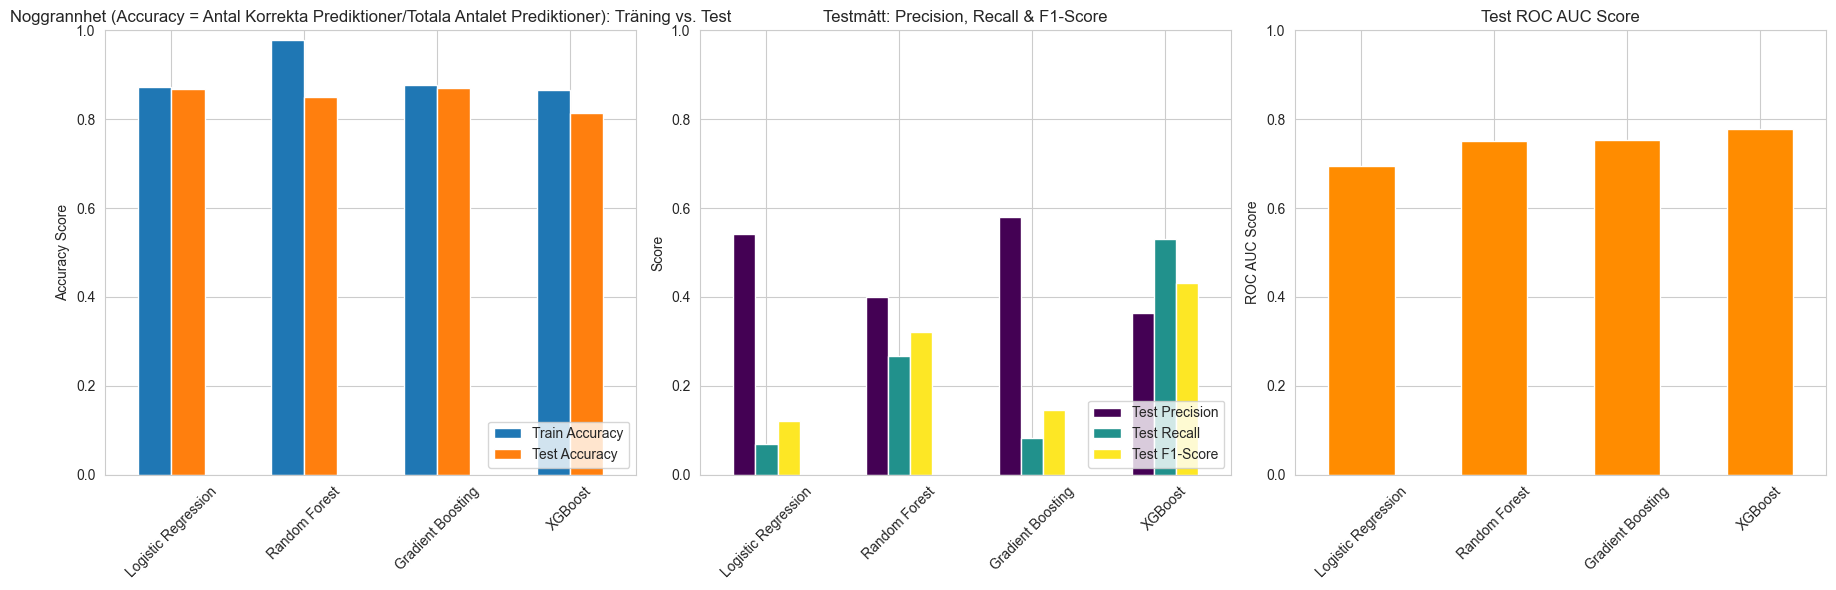

In [47]:
# Visa resultat
# Ställer in att alla flyttal (floats) ska visas med 2 decimaler
# formatet '{:.2f}' betyder 2 decimaler fastställda ('f' för float)
pd.options.display.float_format = '{:.2f}'.format

results_df = pd.DataFrame(results).T
print("\nModel Classification Performance Comparison:")
display(results_df)

# Visualisera
fig, axes = plt.subplots(1, 3, figsize=(18, 6)) # Ändrat till 1 rad, 3 kolumner för att visa fler mått

# --- Diagram 1: Accuracy (Noggrannhet) ---
# Jämför Träning (Train) och Test Accuracy för att upptäcka överanpassning
results_df[['Train Accuracy', 'Test Accuracy']].plot(kind='bar', ax=axes[0])
axes[0].set_title('Noggrannhet (Accuracy = Antal Korrekta Prediktioner/Totala Antalet Prediktioner): Träning vs. Test')
axes[0].set_ylabel('Accuracy Score')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(loc='lower right')
axes[0].set_ylim(0.0, 1.0) # Sätt rimliga gränser

# --- Diagram 2: Viktiga Prediktionsmått (Precision, Recall, F1) ---
# Visar de viktigaste testmåtten för balans och tillförlitlighet
results_df[['Test Precision', 'Test Recall', 'Test F1-Score']].plot(kind='bar', ax=axes[1], cmap='viridis')
axes[1].set_title('Testmått: Precision, Recall & F1-Score')
axes[1].set_ylabel('Score')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(loc='lower right')
axes[1].set_ylim(0.0, 1.0) # Sätt rimliga gränser

# --- Diagram 3: ROC AUC (Modellens åtskiljande förmåga) ---
# ROC AUC är ett utmärkt sammanfattande mått för binär klassificering
results_df['Test ROC AUC'].plot(kind='bar', ax=axes[2], color='darkorange')
axes[2].set_title('Test ROC AUC Score')
axes[2].set_ylabel('ROC AUC Score')
axes[2].tick_params(axis='x', rotation=45)
axes[2].set_ylim(0.0, 1.0) # Sätt rimliga gränser

plt.tight_layout()
plt.show()

### Analys av Modellers Prestanda

Resultaten ovan jämför de fyra klassificeringsmodellernas förmåga att förutsäga en tågförsening (klass 1) eller att tåget går i tid (klass 0).

#### ROC AUC Score

**ROC AUC** står för **Receiver Operating Characteristic - Area Under the Curve**.

* **Mått på separation:** ROC AUC är det viktigaste måttet för att utvärdera hur bra en klassificeringsmodell är på att skilja mellan de två klasserna (i detta fall: "I tid" och "Försenad").
* **Skala:** Värdet sträcker sig från 0.0 till 1.0.
    * **0.5:** Representerar en modell som gissar slumpmässigt (inte bättre än att singla slant).
    * **1.0:** Representerar en perfekt modell som kan skilja de två klasserna utan några fel.
* **Tolkning:** En modell med ROC AUC på cirka **0.78 (XGBoost)** visar på en stark förmåga att på ett tillförlitligt sätt ranka tåg efter risk för försening.

### Hyperparameter Tuning

In [48]:
# Hyperparameter tuning för bästa modellen XGBoost

param_grid_xgb = {
    'n_estimators': [150, 200, 225],        # Antal träd i modellen, 150
    'max_depth': [7, 9, 10],                # Antalet nivåer i varje träd, 10
    'learning_rate': [0.05, 0.1],           # Justera inlärningstakten. Lägre = bättre precision, men långsammare. 0.05
    'colsample_bytree': [0.6, 0.7],         # Styr hur aggressivt trädet får lära sig (standard = 1). Ett lägre värde kan hjälpa. 0.6
    'scale_pos_weight': [3.5, 4, 4.5]       # Vikt för att hantera obalanserad data 4
}

# 1. Initiera XGBoost-klassificeraren
xgb = XGBClassifier(
    random_state=42, 
    n_jobs=-1,
    # Använd din beprövade vikt för att hantera obalanserad data
    # scale_pos_weight=4.5, # Används i grid search instället
    # Måste inkluderas för moderna versioner av XGBoost i scikit-learn
    use_label_encoder=False, 
    eval_metric='logloss' 
)

# 2. Initiera GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb, 
    param_grid=param_grid_xgb, 
    cv=5, 
    # Ändrat scoring till 'f1' för att optimera balansen mellan Precision och Recall
    scoring='f1', # Viktigt för obalanserad data
    n_jobs=-1, 
    verbose=3 # Ökade verbose för att se mer detaljerad utskrift under körning
)

# 3. Träna modellen
# OBS: X_train_scaled och y_train är redan definierade från tidigare celler
print("\nStartar Grid Search för XGBoost Classifier...")
grid_search.fit(X_train_scaled, y_train)

print("\n" + "="*50)
print("Bästa parametrar (XGBoost):", grid_search.best_params_)
# Vi utvärderar nu med F1-Score
print(f"Bästa CV F1-Score: {grid_search.best_score_:.4f}") 
print("="*50)



Startar Grid Search för XGBoost Classifier...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Bästa parametrar (XGBoost): {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 150, 'scale_pos_weight': 4.5}
Bästa CV F1-Score: 0.4361


In [49]:
# Träna final modell (Hämta den bästa estimatormodellen från Grid Search)
best_model = grid_search.best_estimator_

# Predicera KLASSER (0 eller 1)
y_pred_final = best_model.predict(X_test_scaled)

# Predicera SANNOLIKHETER (Behövs för ROC AUC)
# Vi tar sannolikheten för den positiva klassen (klass 1)
y_proba_final = best_model.predict_proba(X_test_scaled)[:, 1] 

print("\nFinal modell tränad och prediktioner genererade!")


Final modell tränad och prediktioner genererade!


###

### Final Evaluation and Feature Importance

In [50]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix

# Beräkna final metrics
accuracy = accuracy_score(y_test, y_pred_final)
f1 = f1_score(y_test, y_pred_final)
precision = precision_score(y_test, y_pred_final)
recall = recall_score(y_test, y_pred_final)
roc_auc = roc_auc_score(y_test, y_proba_final)

# Beräkna Confusion Matrix för en mer detaljerad tolkning
cm = confusion_matrix(y_test, y_pred_final)
tn, fp, fn, tp = cm.ravel()

print("\n" + "="*60)
print("FINAL XGBOOST CLASSIFIER PERFORMANCE")
print("="*60)
print(f"Accuracy (Noggrannhet):     {accuracy:.4f}")
print(f"Precision:                  {precision:.4f}")
print(f"Recall (Träffsäkerhet):     {recall:.4f}")
print(f"F1-Score:                   {f1:.4f}")
print(f"ROC AUC Score:              {roc_auc:.4f}")
print("="*60)

print("\nTolkning av Recall (viktigast för förseningar):")
print(f"- Modellen hittar {recall:.2%} av alla faktiska förseningar.")

print("\nDETALJERAD TOLKNING (Confusion Matrix):")
print(f"- Korrekt förutspådda förseningar (True Positives, TP):     {tp}")
print(f"- Missade förseningar (False Negatives, FN):                {fn}")
print(f"- Falska larm (False Positives, FP):                        {fp}")
print(f"- Korrekt förutspådd icke-försening (True Negatives, TN):   {tn}")

print(f"\nMatrisen: \n{cm}")


FINAL XGBOOST CLASSIFIER PERFORMANCE
Accuracy (Noggrannhet):     0.8235
Precision:                  0.3778
Recall (Träffsäkerhet):     0.5057
F1-Score:                   0.4325
ROC AUC Score:              0.7857

Tolkning av Recall (viktigast för förseningar):
- Modellen hittar 50.57% av alla faktiska förseningar.

DETALJERAD TOLKNING (Confusion Matrix):
- Korrekt förutspådda förseningar (True Positives, TP):     581
- Missade förseningar (False Negatives, FN):                568
- Falska larm (False Positives, FP):                        957
- Korrekt förutspådd icke-försening (True Negatives, TN):   6536

Matrisen: 
[[6536  957]
 [ 568  581]]


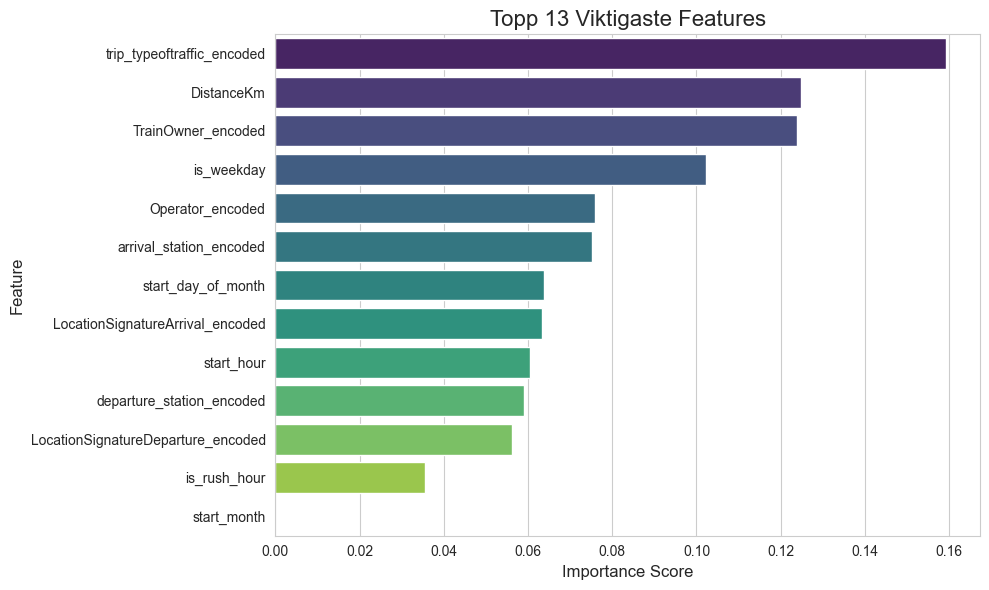


Topp 10 viktigaste features:


,feature,importance
0,trip_typeoftraffic_encoded,0.16
1,DistanceKm,0.12
2,TrainOwner_encoded,0.12
3,is_weekday,0.10
4,Operator_encoded,0.08
5,arrival_station_encoded,0.08
6,start_day_of_month,0.06
7,LocationSignatureArrival_encoded,0.06
8,start_hour,0.06
9,departure_station_encoded,0.06


In [51]:
# Feature importance
if hasattr(best_model, 'feature_importances_'):
    
    # Skapa DataFrame (Samma som innan)
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False).reset_index(drop=True)
    
    # Bestäm antalet features som ska visas
    top_n = min(15, len(feature_importance))
    plot_data = feature_importance.head(top_n)
    
    # --- Seaborn Visualisering ---
    plt.figure(figsize=(10, 6))
    
    # Använd Seaborns barplot
    sns.barplot(
        x='importance',            # X-axeln: Värdet (vikten)
        y='feature',               # Y-axeln: Feature-namnet
        data=plot_data,            # Datakällan (endast top N)
        palette='viridis'          # Använd ett snyggt färgschema
    )
    
    plt.title(f'Topp {top_n} Viktigaste Features', fontsize=16)
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    # Seaborn sorterar automatiskt staplarna i den ordning de kommer i datat, 
    # så du behöver inte 'invert_yaxis()'
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nTopp 10 viktigaste features:")
    display(feature_importance.head(10))

else:
    print("Modellen (best_model) har ingen 'feature_importances_'-attribut.")

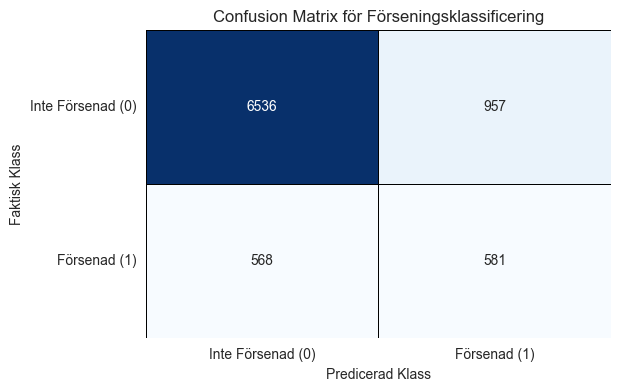


Matrisinnehåll:
Övre vänster (True Negatives): 6536 - Korrekt förutspådd i tid.
Övre höger (False Positives): 957 - Falska larm (Predicerad försening, men i tid).
Nedre vänster (False Negatives): 568 - Missade förseningar (Predicerad i tid, men försenad).
Nedre höger (True Positives): 581 - Korrekt förutspådd försening.


In [52]:
# Beräkna Confusion Matrix (y_test och y_pred_final är redan definierade)
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(6, 4))
# Visualisera matrisen
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    cbar=False,
    linewidths=0.5,
    linecolor='black'
)

# Sätt etiketter för klasserna (0 = Inte Försenad, 1 = Försenad)
plt.xlabel('Predicerad Klass')
plt.ylabel('Faktisk Klass')
plt.xticks([0.5, 1.5], ['Inte Försenad (0)', 'Försenad (1)'])
plt.yticks([0.5, 1.5], ['Inte Försenad (0)', 'Försenad (1)'], rotation=0)
plt.title('Confusion Matrix för Förseningsklassificering')
plt.show()

# Extra tolkning direkt under matrisen
print("\nMatrisinnehåll:")
print(f"Övre vänster (True Negatives): {cm[0, 0]} - Korrekt förutspådd i tid.")
print(f"Övre höger (False Positives): {cm[0, 1]} - Falska larm (Predicerad försening, men i tid).")
print(f"Nedre vänster (False Negatives): {cm[1, 0]} - Missade förseningar (Predicerad i tid, men försenad).")
print(f"Nedre höger (True Positives): {cm[1, 1]} - Korrekt förutspådd försening.")

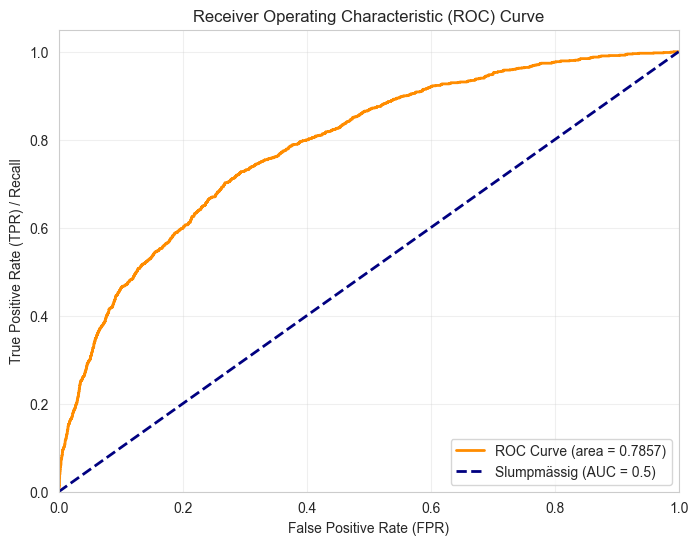


ROC Curve Tolkning:
- ROC AUC på 0.7857 bekräftar modellens starka förmåga att skilja mellan en försenad och icke-försenad klass.
- Ju längre kurvan är från den diagonala linjen, desto bättre är klassificeringen.


In [53]:
# Beräkna False Positive Rate (FPR), True Positive Rate (TPR) och trösklar
# y_proba_final är redan definierad som sannolikheten för klass 1 (försening)
fpr, tpr, thresholds = roc_curve(y_test, y_proba_final)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(
    fpr, tpr, 
    color='darkorange', 
    lw=2, 
    label=f'ROC Curve (area = {roc_auc:.4f})'
)
# Linje för slumpmässig gissning (AUC = 0.5)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Slumpmässig (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) / Recall')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

# Utskrift av tolkning
print("\nROC Curve Tolkning:")
print(f"- ROC AUC på {roc_auc:.4f} bekräftar modellens starka förmåga att skilja mellan en försenad och icke-försenad klass.")
print("- Ju längre kurvan är från den diagonala linjen, desto bättre är klassificeringen.")

In [54]:
# Spara modell och scaler för framtida användning
import joblib

# Spara modell
joblib.dump(best_model, 'train_delay_model.pkl')
joblib.dump(scaler, 'train_delay_scaler.pkl')
joblib.dump(label_encoders, 'train_delay_encoders.pkl')

print("Modell sparad!")
print("\nFör att ladda modellen senare:")
print("loaded_model = joblib.load('train_delay_model.pkl')")
print("loaded_scaler = joblib.load('train_delay_scaler.pkl')")
print("loaded_encoders = joblib.load('train_delay_encoders.pkl')")


Modell sparad!

För att ladda modellen senare:
loaded_model = joblib.load('train_delay_model.pkl')
loaded_scaler = joblib.load('train_delay_scaler.pkl')
loaded_encoders = joblib.load('train_delay_encoders.pkl')


In [55]:
# Ladda planerad data för att titta på dess struktur
file_path_planned = os.path.join('data', 'trips_planned_latest.parquet')
df_planned_data = pd.read_parquet(file_path_planned)

In [56]:
print(df_planned_data.dtypes)
print("-------------------")
print(df_processed.dtypes)

AdvertisedTrainIdent            object
service_date            datetime64[ns]
Tripdate                datetime64[ns]
start_planned           datetime64[ns]
end_planned             datetime64[ns]
duration_minutes               float64
start_station                   object
end_station                     object
stops_count                      int64
through_stations                object
any_canceled                      Int8
Operator                        object
TrainOwner                      object
FromLocations                   object
ToLocations                     object
start_operator                  object
start_owner                     object
start_typeoftraffic             object
start_deviation                 object
start_hour                       int64
start_weekday_                   int64
start_mounth                     int64
is_weekday                       int64
distance_km                    float64
dtype: object
-------------------
AdvertisedTrainIdent          

In [57]:
print(df_planned_data.dtypes)
print(df_planned_data['end_station'].head(10))
print(df_processed['end_station_county'].head(10))

AdvertisedTrainIdent            object
service_date            datetime64[ns]
Tripdate                datetime64[ns]
start_planned           datetime64[ns]
end_planned             datetime64[ns]
duration_minutes               float64
start_station                   object
end_station                     object
stops_count                      int64
through_stations                object
any_canceled                      Int8
Operator                        object
TrainOwner                      object
FromLocations                   object
ToLocations                     object
start_operator                  object
start_owner                     object
start_typeoftraffic             object
start_deviation                 object
start_hour                       int64
start_weekday_                   int64
start_mounth                     int64
is_weekday                       int64
distance_km                    float64
dtype: object
0     NR
1     MC
2     DU
3    CST
4    HIE
5    

### Prediktionskedjan

In [58]:
# --- STEG 1: Ladda sparade objekt och lägg till UNKNOWN ---
try:
    loaded_model = joblib.load('train_delay_model.pkl')
    loaded_scaler = joblib.load('train_delay_scaler.pkl')
    loaded_label_encoders = joblib.load('train_delay_encoders.pkl')
    

    # FIX: Tvinga in 'UNKNOWN' i alla Label Encoders och stabilisera arrayen
    for col, le in loaded_label_encoders.items():

        # <<< DEBUGGING HÄR >>>
        print("-" * 50)
        print(f"DEBUG '{col}': Ursprunglig le.classes_ före fix:")
        print(f"  Typ: {type(le.classes_)}")
        try:
            print(f"  Form: {le.classes_.shape}")
        except AttributeError:
            print(f"  Form: Kan inte bestämmas")
        print(f"  Första 5 element: {le.classes_[:5]}")
        
        # 1. Stabilisera classes_ till en ren 1D NumPy-array
        le.classes_ = np.asarray(le.classes_).ravel()
        
        # 2. Lägg till 'UNKNOWN' om den saknas
        if 'UNKNOWN' not in le.classes_:
            # Använd np.append och .ravel() för att säkerställa 1D-format
            le.classes_ = np.append(le.classes_, 'UNKNOWN').ravel()
            print(f"✓ Lade till 'UNKNOWN' i Label Encoder för '{col}'.")
        
        # NY DEBUG: Efter fix
        print(f"DEBUG '{col}': Efter fix, Form: {le.classes_.shape}")
        print("-" * 50)
    
    print("\n✓ Modell, Scaler och Encoders laddade framgångsrikt.\n")

except FileNotFoundError as e:
    print(f"❌ FEL: Kunde inte hitta fil: {e}")
    raise


# --- STEG 2: Ladda ny planerad data (MED INDEX KONTROLL) ---
file_path_planned = os.path.join('data', 'trips_planned_latest.parquet')
df_planned_data = pd.read_parquet(file_path_planned)
df_planned_processed = df_planned_data.copy()
print(f"✓ Laddat ny planerad data: {df_planned_processed.shape[0]} rader")

# KRITISK INDEX DEBUG
if df_planned_processed.index.duplicated().any():
    print(f"❌ KRITISKT FEL: Dubblerade index hittades! Antal: {df_planned_processed.index.duplicated().sum()}")
    # Lösning: Återställ indexet till en enkel heltalssekvens
    df_planned_processed = df_planned_processed.reset_index(drop=True)
    print("✓ Index återställt för att lösa dupliceringsproblem.")
else:
    print("✓ Inga duplicerade index.")
print(f"Total längd på DataFrame: {len(df_planned_processed.index)}\n")


# --- STEG 3: Döp om kolumner för att matcha träningsdata ---
rename_map = {
    'distance_km': 'DistanceKm',
    'any_canceled': 'Canceled',
    'start_weekday_': 'is_weekday', 
    'start_mounth': 'start_month',
    'FromLocations': 'LocationSignatureDeparture',
    'ToLocations': 'LocationSignatureArrival',
    'start_operator': 'Operator',
    'start_owner': 'TrainOwner',
    'start_typeoftraffic': 'trip_typeoftraffic',
    'start_station': 'departure_station',
    'end_station': 'arrival_station',
    'Tripdate': 'TripStartDate'
}

df_planned_processed.rename(columns=rename_map, inplace=True)
print("✓ Kolumnnamn synkroniserade\n")


# --- STEG 4: Skapa saknade kategoriska kolumner ---
required_categorical_cols = [
    'LocationSignatureDeparture', 
    'LocationSignatureArrival', 
    'Operator', 
    'TrainOwner', 
    'trip_typeoftraffic', 
    'departure_station', 
    'arrival_station'
]

for col in required_categorical_cols:
    if col not in df_planned_processed.columns:
        df_planned_processed[col] = 'UNKNOWN'
        print(f"→ Skapade saknad kolumn: '{col}' (fylld med UNKNOWN)")


# --- STEG 5: Konvertera datetime och skapa time-features ---
datetime_cols = ['start_planned', 'end_planned']
for col in datetime_cols:
    if col in df_planned_processed.columns:
        df_planned_processed[col] = pd.to_datetime(df_planned_processed[col])

if 'start_planned' in df_planned_processed.columns:
    df_planned_processed['start_day_of_month'] = df_planned_processed['start_planned'].dt.day
    print("✓ Feature 'start_day_of_month' skapad")

if 'end_planned' in df_planned_processed.columns and 'start_planned' in df_planned_processed.columns:
    df_planned_processed['planned_duration_min'] = (
        df_planned_processed['end_planned'] - df_planned_processed['start_planned']
    ).dt.total_seconds() / 60
    print("✓ Feature 'planned_duration_min' skapad")

if 'start_hour' in df_planned_processed.columns:
    df_planned_processed['is_rush_hour'] = df_planned_processed['start_hour'].isin([7,8,9,16,17,18]).astype(int)
    print("✓ Feature 'is_rush_hour' skapad\n")

print(df_planned_processed['Operator'].shape)
print(df_planned_processed['Operator'].head())
print(df_planned_processed.columns[df_planned_processed.columns.duplicated()])

# --- STEG 6: Applicera Label Encoding (stabil version utan label_enc_mappings) ---
print("Applicerar Label Encoders...\n")

# --- Rensar bort dubblettkolumner på DataFrame-nivå ---
dup_cols = df_planned_processed.columns[df_planned_processed.columns.duplicated()]
if len(dup_cols) > 0:
    print(f"⚠️ Hittade {len(dup_cols)} dubblettkolumner: {list(dup_cols)}")
    # Behåll endast den första förekomsten av varje kolumnnamn
    df_planned_processed = df_planned_processed.loc[:, ~df_planned_processed.columns.duplicated()]
    print("✓ Dubblettkolumner borttagna.\n")

# --- Säkerhetsfix: upptäck och hantera kolumner som blivit DataFrames med flera kopior ---
for col in required_categorical_cols:
    if col in df_planned_processed.columns:
        col_data = df_planned_processed[col]

        # Om kolumnen i själva verket är en DataFrame med flera kolumner:
        if isinstance(col_data, pd.DataFrame):
            print(f"⚠️ Kolumn '{col}' består av {col_data.shape[1]} dubblettkolumner. Tar endast första kolumnen.")
            df_planned_processed[col] = col_data.iloc[:, 0]

        # Om kolumnen är en Series med duplicerade namn i MultiIndex
        elif hasattr(col_data, "columns") and len(getattr(col_data, "columns", [])) > 1:
            print(f"⚠️ Kolumn '{col}' har flera subkolumner. Tar första.")
            df_planned_processed[col] = col_data.iloc[:, 0]

encoded_cols = {}
index_to_use = df_planned_processed.index  # Spara index en gång

for col in required_categorical_cols:
    print(f"\n{'='*40}\nKodning av kolumn: {col}\n{'='*40}")

    if col not in df_planned_processed.columns:
        print(f"⚠️ Kolumn '{col}' saknas i df_planned_processed – hoppar över.")
        continue

    if col not in loaded_label_encoders:
        print(f"⚠️ Ingen LabelEncoder hittades för '{col}' – hoppar över.")
        continue

    le = loaded_label_encoders[col]

    # Kontrollera att encoder har 'UNKNOWN'
    if 'UNKNOWN' not in le.classes_:
        le.classes_ = np.append(le.classes_, 'UNKNOWN')
        print(f"✓ Lade till 'UNKNOWN' i encoder för '{col}' (saknades).")

    # Hämta kolumnvärden som 1D-array
    col_values = df_planned_processed[col].to_numpy(dtype=object, copy=True)
    X_1d_values = np.where(pd.isna(col_values), 'UNKNOWN', col_values).ravel()

    # Skapa mappning från classes_ direkt
    mapping_dict = {cls: idx for idx, cls in enumerate(le.classes_)}
    unknown_index = mapping_dict.get('UNKNOWN', len(le.classes_) - 1)

    # Mappa varje värde till sin kod (okända → UNKNOWN-index)
    transformed_values = np.array([
        mapping_dict.get(str(x), unknown_index)
        for x in X_1d_values
    ], dtype=np.int32)

    # Debug-utskrift
    print("-" * 20)
    print(f"DEBUG {col}:")
    print(f"  Längd på inputvärden: {len(X_1d_values)}")
    print(f"  Längd på transformerade värden: {len(transformed_values)}")
    print(f"  Första 5 kodade värden: {transformed_values[:5]}")
    print("-" * 20)

    # Lagra resultatet som Series
    encoded_cols[col + '_encoded'] = pd.Series(transformed_values, index=index_to_use)
    print(f"✓ {col}_encoded tillagd i encoded_cols.")

# Slå ihop alla kodade kolumner med huvud-DataFrame
if encoded_cols:
    df_planned_processed = pd.concat([df_planned_processed, pd.DataFrame(encoded_cols)], axis=1)
    print(f"\n✅ Alla {len(encoded_cols)} kodade kolumner sammanfogade. Ny shape: {df_planned_processed.shape}\n")
else:
    print("\n⚠️ Inga kolumner kodades – kontrollera required_categorical_cols och encoders.\n")

print("✓ Label Encoding slutförd.\n")



# --- STEG 7: Välj features och skala ---
try:
    X_planned_raw = df_planned_processed[feature_cols]
    print(f"✓ Features valda: {len(feature_cols)} kolumner")
except KeyError as e:
    print(f"\n❌ KRITISKT FEL: Saknade kolumner!")
    missing = set(feature_cols) - set(df_planned_processed.columns)
    print(f"Saknade kolumner ({len(missing)}):")
    for m in sorted(missing):
        print(f"  - {m}")
    raise

# Hantera NaN
nan_count = int(X_planned_raw.isnull().sum().sum())
if nan_count > 0:
    print(f"⚠ Fyller {nan_count} NaN-värden med 0")
    X_planned_raw = X_planned_raw.fillna(0)

# Skala
X_planned_scaled = loaded_scaler.transform(X_planned_raw)
print(f"✓ Data skalad: {X_planned_scaled.shape}\n")


# --- STEG 8: GÖR PREDIKTIONER ---
print("🔮 Gör prediktioner...\n")
predictions = loaded_model.predict(X_planned_scaled)
probabilities = loaded_model.predict_proba(X_planned_scaled)[:, 1]

df_planned_processed['Predicted_Delay'] = predictions
df_planned_processed['Delay_Probability'] = probabilities

# ******************************************************************
# STATISTIK OM PREDIKTIONERNA
# ******************************************************************
num_delayed = int(predictions.sum())
num_ontime = len(predictions) - num_delayed
pct_delayed = (num_delayed / len(predictions)) * 100

print("="*70)
print("✅ PREDIKTIONER SLUTFÖRDA!")
print("="*70)
print(f"📊 Totalt antal tåg: {len(predictions):,}")
print(f"🚨 Förutspådda förseningar: {num_delayed:,} ({pct_delayed:.1f}%)")
print(f"✅ Förutspådda i tid: {num_ontime:,} ({100-pct_delayed:.1f}%)")
print("="*70)
print()
# ******************************************************************

# Visa högrisktåg
high_risk = df_planned_processed[df_planned_processed['Predicted_Delay'] == 1].sort_values(
'Delay_Probability', ascending=False
)

if len(high_risk) > 0:
    print("🚨 TOPP 15 HÖGRISKTÅG FÖR FÖRSENING:")
    print("-" * 70)
 
    # Välj kolumner att visa
    display_cols = []
    possible_cols = [
        ('AdvertisedTrainIdent', 'Tåg ID'),
        ('start_planned', 'Avgångstid'),
        ('departure_station', 'Från Station'),
        ('arrival_station', 'Till Station'),
        ('Operator', 'Operatör'),
        ('TrainOwner', 'Tågägare'),
        ('DistanceKm', 'Distans (km)'),
        ('any_canceled', 'Inställt'),       # Verka inte kunna skrivas ut
        ('stops_count_col', 'Antal Stopp'), # Verka inte kunna skrivas ut
        ('Delay_Probability', 'Risk (%)')
        ]

    for col, label in possible_cols:
        if col in high_risk.columns:
            display_cols.append(col)

    # Formatera och visa
    result = high_risk[display_cols].head(15).copy()

    # Formatera sannolikhet som procent
    if 'Delay_Probability' in result.columns:
        result['Delay_Probability'] = (result['Delay_Probability'] * 100).round(1)

    # Formatera distans
    if 'DistanceKm' in result.columns:
        result['DistanceKm'] = result['DistanceKm'].round(0)
    
    # Döp om kolumnnamnen för snygg presentation och visa
    display_names = {k: v for k, v in possible_cols if k in display_cols}
    display_result = result.rename(columns=display_names)
    display_result = display_result.reset_index(drop=True)
    display(display_result)

    # Beräkna medelvärdet en gång (som ett värde mellan 0.0 och 1.0)
    mean_prob = high_risk['Delay_Probability'].mean()

    # Statistik om högrisktåg
    print("\n📈 STATISTIK FÖR HÖGRISKTÅG:")
    print(f" • Medel sannolikhet:               {mean_prob*100:.1f}%")
    print(f" • Max sannolikhet:                 {high_risk['Delay_Probability'].max()*100:.1f}%")
    print(f" • Antal över 80% risk:             {(high_risk['Delay_Probability'] > 0.8).sum()} st")
    print(f" • Antal över 90% risk:             {(high_risk['Delay_Probability'] > 0.9).sum()} st")
    print(f" • Antal över medel {mean_prob*100:.1f}% risk:      {(high_risk['Delay_Probability'] > mean_prob).sum()} st")

else:
    print("✅ Inga tåg förutspådda med försening!")

print()

# --- STEG 9: EXPORTERA RESULTAT ---

# DEFINIERA export_cols FÖRST (Lösning på NameError)
export_cols = [col for col in ['AdvertisedTrainIdent', 'start_planned', 'departure_station', 'arrival_station',
                               'Operator', 'TrainOwner', 'DistanceKm', 'DelayMinutes',
                               'Predicted_Delay', 'Delay_Probability']
               if col in df_planned_processed.columns]

# Definiera och skapa mappen för export
OUTPUT_DIR = 'predictions'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    print(f"📦 Mappen '{OUTPUT_DIR}' skapades.")

# Tidsstämpel för filnamnen
timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M")

# Exportera alla prediktioner
output_filename = f'predictions_all_{timestamp}.parquet'
output_file_path = os.path.join(OUTPUT_DIR, output_filename)

# Använder den definierade variabeln
df_planned_processed[export_cols].to_parquet(output_file_path, index=False)
print(f"💾 Alla prediktioner exporterade till: {output_file_path}")

# Exportera endast högrisktåg
if len(high_risk) > 0:
    highrisk_filename = f'predictions_highrisk_{timestamp}.parquet'
    highrisk_file_path = os.path.join(OUTPUT_DIR, highrisk_filename)
    
    # Använder den definierade variabeln
    high_risk[export_cols].to_parquet(highrisk_file_path, index=False)
    print(f"🚨 Högrisktåg exporterade till: {highrisk_file_path}")
else:
    print("Inga högrisktåg att exportera.")

print("\n✅ ALLT KLART! 🎉")

--------------------------------------------------
DEBUG 'LocationSignatureDeparture': Ursprunglig le.classes_ före fix:
  Typ: <class 'numpy.ndarray'>
  Form: (269,)
  Första 5 element: ['A' 'Alh' 'Ar' 'Arb' 'Arnc']
✓ Lade till 'UNKNOWN' i Label Encoder för 'LocationSignatureDeparture'.
DEBUG 'LocationSignatureDeparture': Efter fix, Form: (270,)
--------------------------------------------------
--------------------------------------------------
DEBUG 'LocationSignatureArrival': Ursprunglig le.classes_ före fix:
  Typ: <class 'numpy.ndarray'>
  Form: (245,)
  Första 5 element: ['A' 'Alh' 'Ar' 'Ara' 'Arb']
✓ Lade till 'UNKNOWN' i Label Encoder för 'LocationSignatureArrival'.
DEBUG 'LocationSignatureArrival': Efter fix, Form: (246,)
--------------------------------------------------
--------------------------------------------------
DEBUG 'Operator': Ursprunglig le.classes_ före fix:
  Typ: <class 'numpy.ndarray'>
  Form: (14,)
  Första 5 element: ['ARRIVA' 'ATRAIN' 'FSVJ' 'MTRX' 'NJ']


,Tåg ID,Avgångstid,Från Station,Till Station,Operatör,Tågägare,Distans (km),Risk (%)
0,539,2025-10-28 14:24:00,CST,MC,SJ,SJ,512.00,80.20
1,446,2025-10-28 17:19:00,G,CST,SJ,SJ,396.00,78.70
2,505,2025-10-28 15:57:00,CST,MC,SJ,SJ,512.00,78.10
3,541,2025-10-28 15:17:00,CST,MC,SJ,SJ,512.00,78.10
4,545,2025-10-28 17:24:00,CST,MC,SJ,SJ,512.00,77.70
5,7517,2025-10-28 17:39:00,STR,SUC,VY,VY,284.00,77.60
6,12046,2025-10-28 17:24:00,G,CST,MTRX,MTRX,396.00,77.60
7,547,2025-10-28 18:24:00,CST,MC,SJ,SJ,512.00,77.40
8,598,2025-10-28 15:50:00,CST,ÖS,SJ,SJ,464.00,77.20
9,444,2025-10-28 16:19:00,G,CST,SJ,SJ,396.00,75.90



📈 STATISTIK FÖR HÖGRISKTÅG:
 • Medel sannolikhet:               60.8%
 • Max sannolikhet:                 80.2%
 • Antal över 80% risk:             1 st
 • Antal över 90% risk:             0 st
 • Antal över medel 60.8% risk:      96 st

💾 Alla prediktioner exporterade till: predictions\predictions_all_20251029_1150.parquet
🚨 Högrisktåg exporterade till: predictions\predictions_highrisk_20251029_1150.parquet

✅ ALLT KLART! 🎉
